In [46]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import joblib
import pandas as pd
from PIL import Image
import os
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, 
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    confusion_matrix,
    classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression


In [36]:
# Example usage
cnn_model_path = '/home/rohitb/projects/ml/Project/mri_data_analysis/trained_models/cnn_model_1.h5'
sequential_model_path = '/home/rohitb/projects/ml/Project/sequential_data_analysis/trained_models/ensamble_nb_xgb.joblib'
nb_model_path = '/home/rohitb/projects/ml/Project/sequential_data_analysis/trained_models/optimal_gaussianNB.joblib'
xgb_model_path = '/home/rohitb/projects/ml/Project/sequential_data_analysis/trained_models/optimal_XGBoost.joblib'


# MRI Data Preprocessing

In [4]:
raw_data = pd.read_csv('/home/rohitb/projects/ml/Project/data/oasis_cleaned.csv')
data = raw_data[['ID','CDR']]
root_dir = '/home/rohitb/projects/ml/Project/assets/OASIS-1/processed/'
data.head()

,ID,CDR
0,OAS1_0001_MR1,0.0
1,OAS1_0002_MR1,0.0
2,OAS1_0003_MR1,0.5
3,OAS1_0004_MR1,0.5
4,OAS1_0005_MR1,0.5


In [140]:
# Create lists to store images and labels
images = []
labels = []
mri_ids = []

# Walk through all 12 disks
for disk_num in tqdm(range(1, 13), desc='Processing disks'):
    disk_path = os.path.join(root_dir, f'disc{disk_num}')
    for folder in tqdm(os.listdir(disk_path), desc=f'Processing folders in disk {disk_num}', leave=False):
    # for folder in list(os.listdir(disk_path))[:10]:
        folder_path = os.path.join(disk_path, folder)
        if os.path.isdir(folder_path):
            # Get CDR score for this subject
            subject_id = folder  # Append _MR1 to match ID format in data
            try:
                cdr_score = data[data['ID'] == subject_id]['CDR'].values[0]
                
                # Get list of all gif files and take the middle one
                gif_files = [f for f in os.listdir(folder_path) if f.endswith('.gif')]
                if gif_files:
                    middle_img = gif_files[len(gif_files)//2]
                    img_path = os.path.join(folder_path, middle_img)
                    # Open and convert to grayscale numpy array
                    img = Image.open(img_path).convert('L')
                    img = img.resize((128, 128))  # Resize for consistency
                    img_array = np.array(img) / 255.0  # Normalize to [0,1]
                    images.append(img_array)
                    labels.append(cdr_score)
                    mri_ids.append(subject_id)
            except Exception as e:
                print(f"Error processing {subject_id}: {str(e)}")
                raise

# Convert to numpy arrays
mri_X = np.array(images)
mri_y = np.array(labels)


# Create dataframe with image and label columns
mri_dataset = pd.DataFrame({
    'MRI_ID': mri_ids,
    'image': images,  # List of image arrays
    'label': labels,   # List of corresponding labels
})
print(mri_dataset.head())

# Reshape images for CNN input
mri_X = mri_X.reshape(-1, 128, 128, 1)
# Looking at unique CDR values to determine number of classes
unique_cdrs = np.unique(mri_y)
num_classes = len(unique_cdrs)
print(f"Unique CDR values: {unique_cdrs}")
print(f"Number of classes: {num_classes}")
# Display total number of records
print(f"\nTotal number of MRI records: {len(mri_X)}")
print(f"Shape of MRI data array: {mri_X.shape}")
print(f"Shape of labels array: {mri_y.shape}")


Processing disks: 100%|██████████| 12/12 [00:01<00:00,  6.69it/s]


          MRI_ID                                              image  label
0  OAS1_0038_MR1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...    0.5
1  OAS1_0002_MR1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...    0.0
2  OAS1_0014_MR1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...    0.5
3  OAS1_0040_MR1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...    0.5
4  OAS1_0041_MR1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...    0.5
Unique CDR values: [0.  0.5 1.  2. ]
Number of classes: 4

Total number of MRI records: 436
Shape of MRI data array: (436, 128, 128, 1)
Shape of labels array: (436,)


In [143]:
print(raw_data.head())
# Drop unnecessary columns
columns_to_drop = ['Hand']
seq_data = raw_data.drop(columns=columns_to_drop)
# Rename 'Educ' column to 'EDUC' to maintain consistency
seq_data = seq_data.rename(columns={'Educ': 'EDUC'})

cols = data.columns

# Label encode categorical variables
group_label_encoder = LabelEncoder()
gender_label_encoder = LabelEncoder()
seq_data['M/F'] = gender_label_encoder.fit_transform(seq_data['M/F'])

# Handle missing values
data = data.dropna()


labelled_seq_data = seq_data.drop(columns=['ID'])
print(labelled_seq_data.head())

# Make predictions using ensemble models
nb_prob = nb_model.predict_proba(labelled_seq_data)
xgb_prob = xgb_model.predict_proba(labelled_seq_data)

# Combine probabilities as meta-features
meta_features = np.column_stack([nb_prob, xgb_prob])
sequential_model = joblib.load(sequential_model_path)
seq_predictions = []

# Get final predictions for all records using sequential model
seq_pred = sequential_model.predict(meta_features)
seq_predictions.extend(seq_pred)
# Add predictions to dataframe
labelled_seq_data['Group'] = seq_predictions
print(labelled_seq_data.head())


              ID  M/F  Hand   Age  Educ   SES   MMSE  CDR    eTIV   nWBV  \
0  OAS1_0001_MR1  0.0   0.0  74.0  2.00  3.00  29.00  0.0  1344.0  0.743   
1  OAS1_0002_MR1  0.0   0.0  55.0  4.00  1.00  29.00  0.0  1147.0  0.810   
2  OAS1_0003_MR1  0.0   0.0  73.0  4.00  3.00  27.00  0.5  1454.0  0.708   
3  OAS1_0004_MR1  1.0   0.0  28.0  3.39  3.25  22.09  0.5  1588.0  0.803   
4  OAS1_0005_MR1  1.0   0.0  18.0  2.74  3.15  22.55  0.5  1737.0  0.848   

     ASF  
0  1.306  
1  1.531  
2  1.207  
3  1.105  
4  1.010  
   M/F   Age  EDUC   SES   MMSE  CDR    eTIV   nWBV    ASF
0    0  74.0  2.00  3.00  29.00  0.0  1344.0  0.743  1.306
1    0  55.0  4.00  1.00  29.00  0.0  1147.0  0.810  1.531
2    0  73.0  4.00  3.00  27.00  0.5  1454.0  0.708  1.207
3    1  28.0  3.39  3.25  22.09  0.5  1588.0  0.803  1.105
4    1  18.0  2.74  3.15  22.55  0.5  1737.0  0.848  1.010
   M/F   Age  EDUC   SES   MMSE  CDR    eTIV   nWBV    ASF  Group
0    0  74.0  2.00  3.00  29.00  0.0  1344.0  0.743  1.30

/home/rohitb/projects/ml/Project/venv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/rohitb/projects/ml/Project/venv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


 # Training the Combined Model
The hybrid model will be trained using the following approach:

1. **Training Dataset Preparation**
   - Combine MRI scan features and sequential data
   - Normalize and preprocess input features
   - Create balanced training batches

2. **Model Architecture**
   - Configure MLP layers and parameters
   - Set up loss function and optimizer
   - Initialize model weights

3. **Training Process** 
   - Train model using mini-batch gradient descent
   - Monitor training metrics and loss
   - Implement early stopping if needed
   - Save model checkpoints

4. **Hyperparameter Tuning**
   - Optimize learning rate
   - Adjust batch size
   - Fine-tune network architecture
   - Cross-validate parameters

The model will be trained iteratively while monitoring convergence and avoiding overfitting.


In [144]:
print(labelled_seq_data.head())
data = raw_data.copy()
data['Group'] = labelled_seq_data['Group']
print(data.head())


   M/F   Age  EDUC   SES   MMSE  CDR    eTIV   nWBV    ASF  Group
0    0  74.0  2.00  3.00  29.00  0.0  1344.0  0.743  1.306      2
1    0  55.0  4.00  1.00  29.00  0.0  1147.0  0.810  1.531      2
2    0  73.0  4.00  3.00  27.00  0.5  1454.0  0.708  1.207      1
3    1  28.0  3.39  3.25  22.09  0.5  1588.0  0.803  1.105      1
4    1  18.0  2.74  3.15  22.55  0.5  1737.0  0.848  1.010      1
              ID  M/F  Hand   Age  Educ   SES   MMSE  CDR    eTIV   nWBV  \
0  OAS1_0001_MR1  0.0   0.0  74.0  2.00  3.00  29.00  0.0  1344.0  0.743   
1  OAS1_0002_MR1  0.0   0.0  55.0  4.00  1.00  29.00  0.0  1147.0  0.810   
2  OAS1_0003_MR1  0.0   0.0  73.0  4.00  3.00  27.00  0.5  1454.0  0.708   
3  OAS1_0004_MR1  1.0   0.0  28.0  3.39  3.25  22.09  0.5  1588.0  0.803   
4  OAS1_0005_MR1  1.0   0.0  18.0  2.74  3.15  22.55  0.5  1737.0  0.848   

     ASF  Group  
0  1.306      2  
1  1.531      2  
2  1.207      1  
3  1.105      1  
4  1.010      1  


In [145]:
# Training the Hybrid Model
# nb_train_probs = nb_model.predict_proba(labelled_seq_data)
# xgb_train_probs = xgb_model.predict_proba(labelled_seq_data)
# meta_features = np.column_stack([nb_train_probs, xgb_train_probs])
# sequential_predictions = sequential_model.predict(meta_features)

final_dataset = pd.DataFrame(columns=['MRI_ID','mri_pred', 'seq_data_pred', 'Group'])
# Map MRI_IDs to their corresponding Groups from the data DataFrame
final_dataset['MRI_ID'] = mri_ids
cnn_model = load_model(cnn_model_path)
mri_pred = cnn_model.predict(mri_X)
final_dataset['mri_pred'] = np.argmax(mri_pred, axis=1)
print(final_dataset.head())
# Count the number of predictions in mri_pred column
print(f"Number of MRI predictions: {len(final_dataset['mri_pred'])}")




14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step
          MRI_ID  mri_pred seq_data_pred Group
0  OAS1_0038_MR1         0           NaN   NaN
1  OAS1_0002_MR1         0           NaN   NaN
2  OAS1_0014_MR1         0           NaN   NaN
3  OAS1_0040_MR1         0           NaN   NaN
4  OAS1_0041_MR1         0           NaN   NaN
Number of MRI predictions: 436


In [146]:
final_dataset['Group'] = final_dataset['MRI_ID'].map(data.set_index('ID')['Group'])
print(final_dataset.head())

          MRI_ID  mri_pred seq_data_pred  Group
0  OAS1_0038_MR1         0           NaN      1
1  OAS1_0002_MR1         0           NaN      2
2  OAS1_0014_MR1         0           NaN      1
3  OAS1_0040_MR1         0           NaN      1
4  OAS1_0041_MR1         0           NaN      1


In [147]:
# Get sequential data predictions for each MRI_ID
seq_predictions = []
print(seq_data.head())
for mri_id in tqdm(final_dataset['MRI_ID'], desc="Processing sequential predictions"):
    # Get corresponding sequential data record
    seq_record = seq_data[seq_data['ID'] == mri_id].drop('ID', axis=1)
    # Make predictions using ensemble models
    nb_prob = nb_model.predict_proba(seq_record)
    xgb_prob = xgb_model.predict_proba(seq_record)
    
    # Combine probabilities as meta-features
    meta_features = np.column_stack([nb_prob, xgb_prob])
    sequential_model = joblib.load(sequential_model_path)
    # Get final prediction using sequential model
    seq_pred = sequential_model.predict(meta_features)
    seq_predictions.append(seq_pred[0])
    
# Add sequential predictions to final dataset
final_dataset['seq_data_pred'] = seq_predictions

print("Sequential predictions added to final dataset:")
print(final_dataset.head())

              ID  M/F   Age  EDUC   SES   MMSE  CDR    eTIV   nWBV    ASF
0  OAS1_0001_MR1    0  74.0  2.00  3.00  29.00  0.0  1344.0  0.743  1.306
1  OAS1_0002_MR1    0  55.0  4.00  1.00  29.00  0.0  1147.0  0.810  1.531
2  OAS1_0003_MR1    0  73.0  4.00  3.00  27.00  0.5  1454.0  0.708  1.207
3  OAS1_0004_MR1    1  28.0  3.39  3.25  22.09  0.5  1588.0  0.803  1.105
4  OAS1_0005_MR1    1  18.0  2.74  3.15  22.55  0.5  1737.0  0.848  1.010


Processing sequential predictions:   0%|          | 0/436 [00:00<?, ?it/s]/home/rohitb/projects/ml/Project/venv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/rohitb/projects/ml/Project/venv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/rohitb/projects/ml/Project/venv/lib/python3.12/site-

Sequential predictions added to final dataset:
          MRI_ID  mri_pred  seq_data_pred  Group
0  OAS1_0038_MR1         0              1      1
1  OAS1_0002_MR1         0              2      2
2  OAS1_0014_MR1         0              1      1
3  OAS1_0040_MR1         0              1      1
4  OAS1_0041_MR1         0              1      1


In [148]:
# Get unique values in mri_pred column and their counts
unique_mri_preds = final_dataset['mri_pred'].value_counts()
print("\nUnique MRI predictions and their counts:")
print(unique_mri_preds)
print(final_dataset.head())
# Get confidence scores from CNN model predictions
mri_confidences = np.max(mri_pred, axis=1)
final_dataset['mri_confidence'] = mri_confidences

# Get confidence scores from sequential model predictions
seq_confidences = []
for mri_id in tqdm(final_dataset['MRI_ID'], desc="Processing sequential confidences"):
    seq_record = seq_data[seq_data['ID'] == mri_id].drop('ID', axis=1)
    nb_prob = nb_model.predict_proba(seq_record)
    xgb_prob = xgb_model.predict_proba(seq_record)
    meta_features = np.column_stack([nb_prob, xgb_prob])
    sequential_model = joblib.load(sequential_model_path)
    seq_prob = sequential_model.predict_proba(meta_features)
    seq_confidences.append(np.max(seq_prob))

final_dataset['seq_data_confidence'] = seq_confidences

print("\nDataset with confidence scores:")
print(final_dataset.head())




Unique MRI predictions and their counts:
mri_pred
0    416
1     20
Name: count, dtype: int64
          MRI_ID  mri_pred  seq_data_pred  Group
0  OAS1_0038_MR1         0              1      1
1  OAS1_0002_MR1         0              2      2
2  OAS1_0014_MR1         0              1      1
3  OAS1_0040_MR1         0              1      1
4  OAS1_0041_MR1         0              1      1


Processing sequential confidences:   0%|          | 0/436 [00:00<?, ?it/s]/home/rohitb/projects/ml/Project/venv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/rohitb/projects/ml/Project/venv/lib/python3.12/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.4.1.post1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/rohitb/projects/ml/Project/venv/lib/python3.12/site-


Dataset with confidence scores:
          MRI_ID  mri_pred  seq_data_pred  Group  mri_confidence  \
0  OAS1_0038_MR1         0              1      1        1.000000   
1  OAS1_0002_MR1         0              2      2        1.000000   
2  OAS1_0014_MR1         0              1      1        1.000000   
3  OAS1_0040_MR1         0              1      1        1.000000   
4  OAS1_0041_MR1         0              1      1        0.999999   

   seq_data_confidence  
0                 1.00  
1                 0.91  
2                 0.76  
3                 0.82  
4                 0.88  


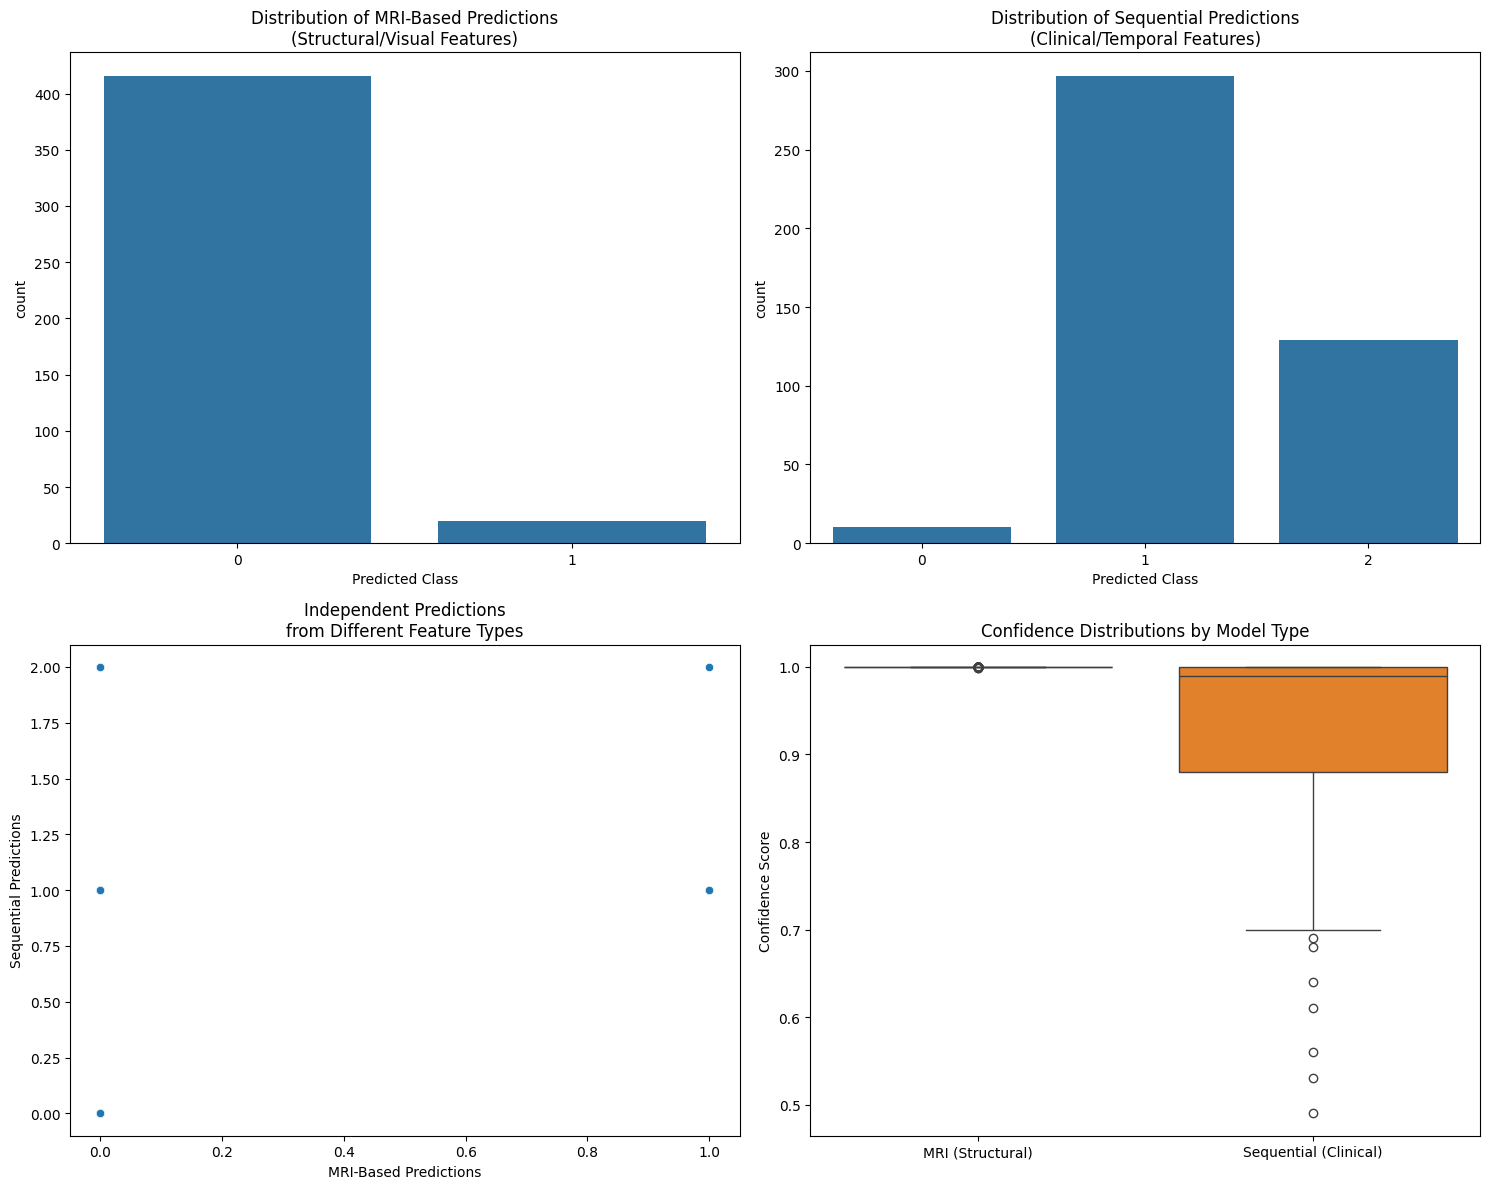

In [149]:
# Visualize the distribution of predictions and confidences
import matplotlib.pyplot as plt
import seaborn as sns
def visualize_predictions(df):
    """
    Create visualizations for model predictions and confidences.
    The MRI and sequential predictions measure different aspects and are not correlated.
    
    Parameters:
    df (DataFrame): DataFrame containing MRI and sequential model predictions and confidences
                   Required columns: mri_id, mri_pred, mri_confidence, seq_data_pred, 
                   seq_data_confidence, group
    """
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot CNN prediction distributions
    sns.countplot(x=df['mri_pred'], ax=axes[0,0])
    axes[0,0].set_title('Distribution of MRI-Based Predictions\n(Structural/Visual Features)')
    axes[0,0].set_xlabel('Predicted Class')
    
    # Plot sequential prediction distributions
    sns.countplot(x=df['seq_data_pred'], ax=axes[0,1])
    axes[0,1].set_title('Distribution of Sequential Predictions\n(Clinical/Temporal Features)')
    axes[0,1].set_xlabel('Predicted Class')
    
    # Show complementary nature of predictions
    sns.scatterplot(data=df, x='mri_pred', y='seq_data_pred', ax=axes[1,0])
    axes[1,0].set_title('Independent Predictions\nfrom Different Feature Types')
    axes[1,0].set_xlabel('MRI-Based Predictions')
    axes[1,0].set_ylabel('Sequential Predictions')
    
    # Compare confidence levels
    confidence_data = {
        'MRI (Structural)': df['mri_confidence'],
        'Sequential (Clinical)': df['seq_data_confidence']
    }
    sns.boxplot(data=confidence_data, ax=axes[1,1])
    axes[1,1].set_title('Confidence Distributions by Model Type')
    axes[1,1].set_ylabel('Confidence Score')
    
    plt.tight_layout()
    plt.show()

visualize_predictions(final_dataset.drop(columns=['Group']))